In [22]:
import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ttach as tta

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)
import albumentations
from torchmetrics import F1Score
from PIL import Image
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.utils.class_weight import compute_class_weight
    
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# EDA

In [60]:
PATH_TRAIN =  "data_ext/train/"
PATH_TEST = "data_ext/public_test/"
classes = ['Red', 'Green', 'Violet', 'White', 'Yellow', 'Brown', 'Black', 'Blue', 'Cyan', 'Grey', 'Orange']
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"data_ext/train/{class_name}")))
print('Num of pics: ', sum(counts))

Num of pics:  11490


<BarContainer object of 11 artists>

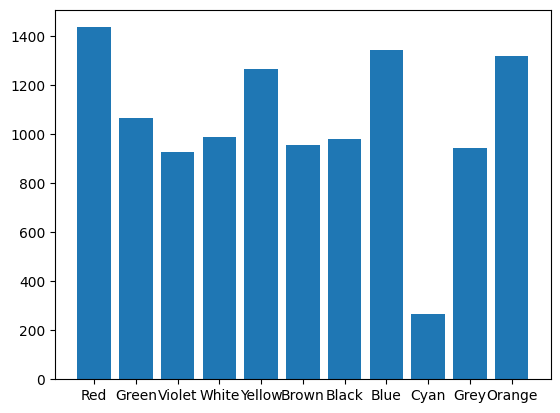

In [61]:
plt.bar(classes, counts)

# Dataset

In [62]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256,256))])

In [63]:
train_dataset = torchvision.datasets.ImageFolder('data_ext/train', transform=transf)
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

In [64]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

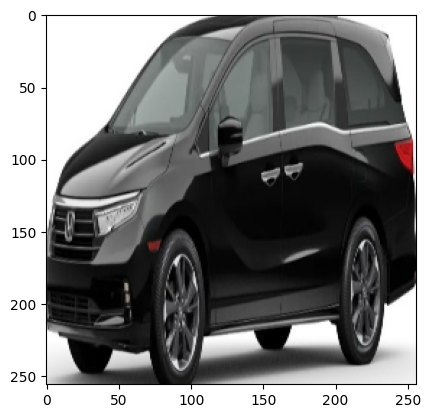

In [65]:
plt.imshow(train_dataset[795][0].permute(1, 2, 0))

# Losses

In [66]:
class FocalLoss(nn.Module):
    def __init__(self, weight, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

# Model class

In [67]:
class ResNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        del backbone.fc
        self.backbone.dropout = nn.Dropout(p=0.1)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
        return out

In [110]:
class EfficentNet(nn.Module):
    def __init__(self, backbone, output_dim, num_of_efficenet):
        super().__init__()
        self.backbone = backbone
        self.features = {0: 1280, 1: 1280, 2: 1408, 3: 1536} 
        self.backbone.classifier[0] = nn.Dropout(p=0.17, inplace=True)
        self.backbone.classifier[1] = torch.nn.Linear(in_features=self.features[num_of_efficenet],
                                                      out_features=output_dim, bias=True)
    def forward(self, image):
        out = self.backbone(image)
        return out

# Loops

In [113]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.to(device)
    model.train()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0

    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(image)
        
        preds.append(logits.argmax(dim=1))
        targets.append(target)
                
        loss = loss_function(logits, target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc.item(),
        "Train F1": f1_score.item()
    }
    
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(image)
            preds.append(logits.argmax(dim=1))
            targets.append(target)
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc.item(),
        "Eval F1": f1_score.item()
    }
    
    return metrics

In [114]:
def cross_validation(project_name,
                     model, 
                     dataset, 
                     loss_function, 
                     strat_array=None,
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle: bool=True, 
                     n_folds: int=4, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate=None):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                else:
                    nn.init.normal_(p)
                    
            optimizer = MADGRAD(model.parameters(), lr = lr)
            #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
            
            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size,
                          shuffle=shuffle)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size,
                          shuffle=shuffle)
            
            total_steps = len(train_loader) * epochs 
            scheduler = get_linear_schedule_with_warmup(optimizer, 
                                    num_warmup_steps = 0, # Default value in run_glue.py
                                    num_training_steps = total_steps)
            mrrs = []

            for epoch_i in range(0, epochs):
                train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
                eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
                
                print(f"EPOCH: {epoch_i + 1}")
                print(f"LR: {scheduler.get_last_lr()}")
                print(train_metrics)
                print(eval_metrics)


def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle=True,
                     epochs: int=15, 
                     lr: float=1e-6,
                     batch_size: int=32,
                     start_epoch=0
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(model.parameters(), lr = lr)

    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle
                                            )
    total_steps = len(data_loader) * epochs 
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                            num_warmup_steps = 0, 
                            num_training_steps = total_steps)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.6)

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            train_metrics = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            print("EPOCH: ", epoch_i + 1)
            print(f"LR: {scheduler.get_last_lr()}")
            print(train_metrics)

# Model, weights, loss

In [115]:
strat_array = []
target_class = 0
for folder in os.listdir(PATH_TRAIN):
    for _ in range(len(os.listdir('data_ext/train' + f'/{folder}'))):
        strat_array.append(target_class)
    target_class += 1

In [116]:
n = len(strat_array)
weights = []
classes = np.arange(11)
correct_weights = compute_class_weight(class_weight = 'balanced',
                                       classes = classes,
                                       y = np.array(strat_array))

In [127]:
model_back_ef1 = torchvision.models.efficientnet_b1(weights='IMAGENET1K_V1')
model_ef1 = EfficentNet(model_back_ef1, 11, num_of_efficenet=1)

In [128]:
loss_function = FocalLoss(weight=torch.tensor(correct_weights).float())

# CV and train

In [ ]:
cross_validation(project_name="car_classification",
                     model=model_ef2, 
                     dataset=train_dataset,
                     strat_array=strat_array,
                     loss_function=loss_function, 
                     device=torch.device("cuda"),
                     random_state=44, 
                     n_folds=3, 
                     epochs=35, 
                     lr=1.1e-5,
                     start_fold=0, 
                     batch_size=16)

In [ ]:
for p in model_ef_3.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    else:
        nn.init.normal_(p)

In [132]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
single_model(model_ef1, 
            train_dataset, 
            loss_function, 
            device = torch.device("cuda"),
            random_state = 44, 
            shuffle = True,
            epochs = 1, 
            lr = 1e-6,
            batch_size=16,
)

In [190]:
torch.save(model_ef1.state_dict(), 'ef1_rs44_40ep.pt')

In [191]:
torch.cuda.empty_cache()

# Predicts and submit

In [193]:
def predict(model, device, root=PATH_TEST, transform=transf):
    model.eval()
    model.to(device)
    
    preds = []
    
    img_files = sorted(os.listdir(root), key=lambda x: int(x.split(".")[0]))
    for img_file in tqdm(img_files):
        image_path= os.path.join(root, img_file)
        image = Image.open(image_path)
        image = transform(image)
        with torch.no_grad():
            pred = model(image.cuda().unsqueeze(dim=0)).argmax(dim=1).detach().cpu().item()
            preds.append(pred)
            
    return pd.Series(preds)

In [ ]:
preds = predict(model_ef1, device, root="data_ext/public_test/", transform=transf)
print(preds)
preds = preds.apply(lambda x: train_dataset.classes[x])
preds.to_csv("ef1_rs44_40ep.csv", index=False)

In [197]:
tta_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(size = (256, 256)),
                                     torchvision.transforms.RandomHorizontalFlip(),
                                     torchvision.transforms.RandomResizedCrop(230),
                                     torchvision.transforms.ToTensor(),
                                     ])

In [198]:
def predict_tta(model, device, root="data_ext/public_test", transform=transf, tta=1):
    model.eval()
    model.to(device)
    
    img_files = sorted(os.listdir(root), key=lambda x: int(x.split(".")[0]))
    preds = [torch.zeros(11)] * len(img_files)

    ans = []
    for i in tqdm(range(tta)):
        for i, img_file in enumerate(tqdm(img_files)):
            image_path= os.path.join(root, img_file)
            image = Image.open(image_path)
            image = transform(image)
            image = image.to(device)
            with torch.no_grad():
                temp = nn.functional.softmax((model(image.cuda().unsqueeze(dim=0)).detach().cpu()), dim = 1)
                temp = model(image.unsqueeze(dim=0)).detach().cpu()
                preds[i] = preds[i] + temp[0]

    for i in range(len(img_files)):
        ans.append(preds[i].argmax(dim=0).item())
            
    return pd.Series(ans)

In [199]:
preds = predict_tta(model_ef1, device, root="data_ext/public_test/", transform=tta_transforms, tta=3)
print(preds)
preds = preds.apply(lambda x: train_dataset.classes[x])
preds.to_csv("tta_ef1.csv", index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1436 [00:00<?, ?it/s]

  0%|          | 0/1436 [00:00<?, ?it/s]

  0%|          | 0/1436 [00:00<?, ?it/s]

0        8
1        9
2       10
3        5
4        4
        ..
1431    10
1432     0
1433     3
1434    10
1435     8
Length: 1436, dtype: int64
